<a href="https://colab.research.google.com/github/Denis04-M/Fish_Classfication/blob/main/fish_classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pathlib
import random
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
data_dir = pathlib.Path('FishData')

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

360


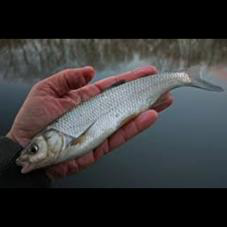

In [ ]:
j = random.randint(0, 100)
dace = list(data_dir.glob('Dace/*'))
PIL.Image.open(str(dace[j]))

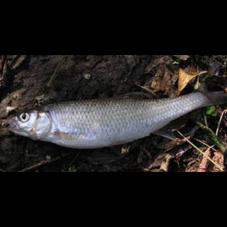

In [ ]:
j = random.randint(0, 100)
perch = list(data_dir.glob('Perch/*'))
PIL.Image.open(str(dace[j]))

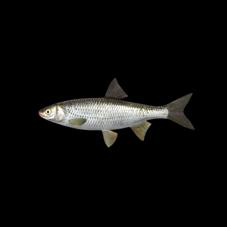

In [ ]:
j = random.randint(0, 100)
roach = list(data_dir.glob('Roach/*'))
PIL.Image.open(str(dace[j]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 360 files belonging to 3 classes.
Using 288 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 360 files belonging to 3 classes.
Using 72 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Dace', 'Perch', 'Roach']


Visualize the data

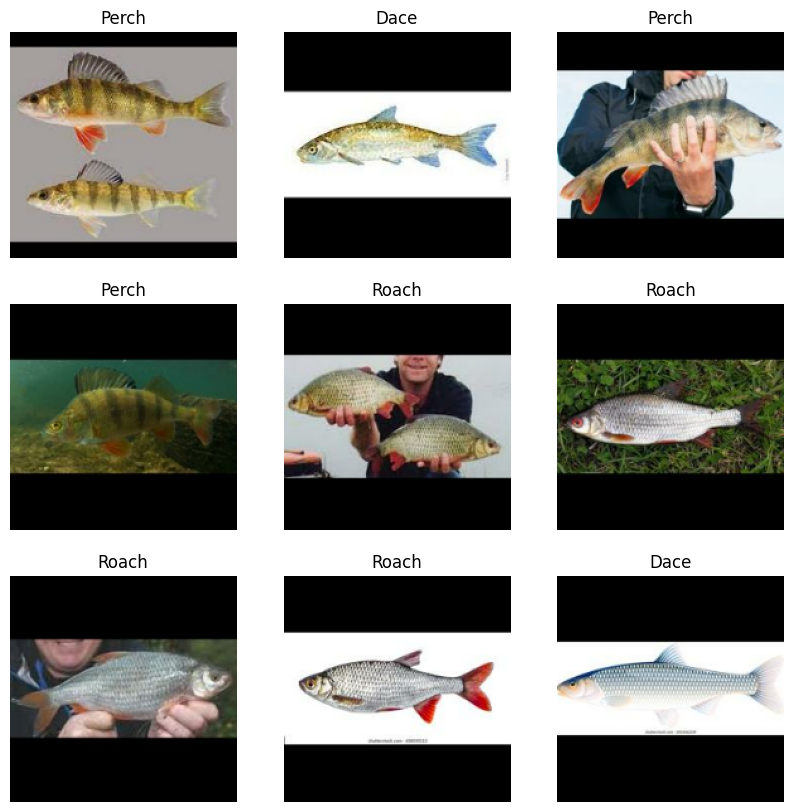

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99718326


Create a classfication model

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

Train the model

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
9/9 [==============================] - 14s 1s/step - loss: 1.7405 - accuracy: 0.4201 - val_loss: 1.0823 - val_accuracy: 0.5278
Epoch 2/10
9/9 [==============================] - 12s 1s/step - loss: 1.0740 - accuracy: 0.5104 - val_loss: 1.0489 - val_accuracy: 0.5417
Epoch 3/10
9/9 [==============================] - 12s 1s/step - loss: 0.9927 - accuracy: 0.5278 - val_loss: 0.9744 - val_accuracy: 0.5833
Epoch 4/10
9/9 [==============================] - 12s 1s/step - loss: 0.8508 - accuracy: 0.6285 - val_loss: 0.9368 - val_accuracy: 0.5417
Epoch 5/10
9/9 [==============================] - 15s 2s/step - loss: 0.7516 - accuracy: 0.6562 - val_loss: 0.8782 - val_accuracy: 0.5694
Epoch 6/10
9/9 [==============================] - 16s 2s/step - loss: 0.6321 - accuracy: 0.7604 - val_loss: 0.8312 - val_accuracy: 0.6250
Epoch 7/10
9/9 [==============================] - 14s 1s/step - loss: 0.5471 - accuracy: 0.7708 - val_loss: 0.8661 - val_accuracy: 0.6528
Epoch 8/10
9/9 [==================

Visualize training results

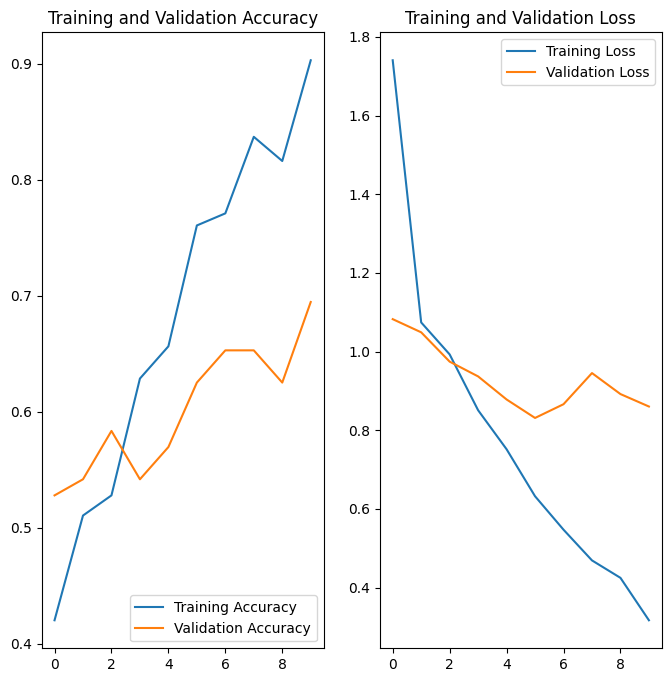

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Data augmentation to reduce Overfitting

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

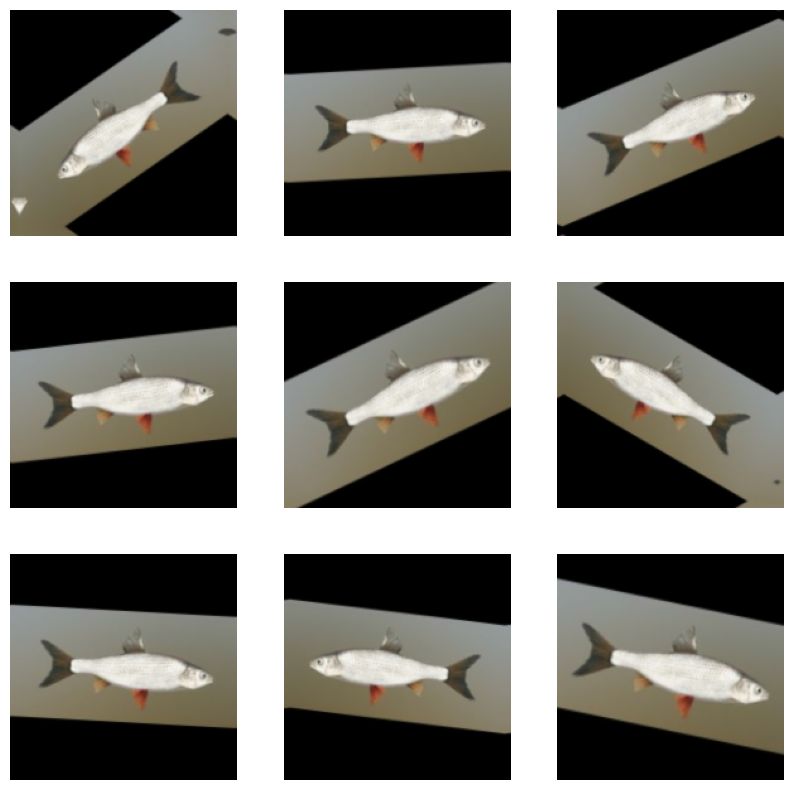

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Dropout to reduce Overfitting

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
9/9 [==============================] - 17s 2s/step - loss: 1.8762 - accuracy: 0.2951 - val_loss: 1.0884 - val_accuracy: 0.3333
Epoch 2/15
9/9 [==============================] - 14s 2s/step - loss: 1.0989 - accuracy: 0.3229 - val_loss: 1.0993 - val_accuracy: 0.2639
Epoch 3/15
9/9 [==============================] - 14s 2s/step - loss: 1.0980 - accuracy: 0.3333 - val_loss: 1.0975 - val_accuracy: 0.3056
Epoch 4/15
9/9 [==============================] - 14s 2s/step - loss: 1.0957 - accuracy: 0.4028 - val_loss: 1.0951 - val_accuracy: 0.4444
Epoch 5/15
9/9 [==============================] - 14s 2s/step - loss: 1.0905 - accuracy: 0.4236 - val_loss: 1.0774 - val_accuracy: 0.4306
Epoch 6/15
9/9 [==============================] - 14s 2s/step - loss: 1.0833 - accuracy: 0.4236 - val_loss: 1.0541 - val_accuracy: 0.4583
Epoch 7/15
9/9 [==============================] - 13s 1s/step - loss: 1.0644 - accuracy: 0.4688 - val_loss: 1.0416 - val_accuracy: 0.5000
Epoch 8/15
9/9 [==================

Visualize training results

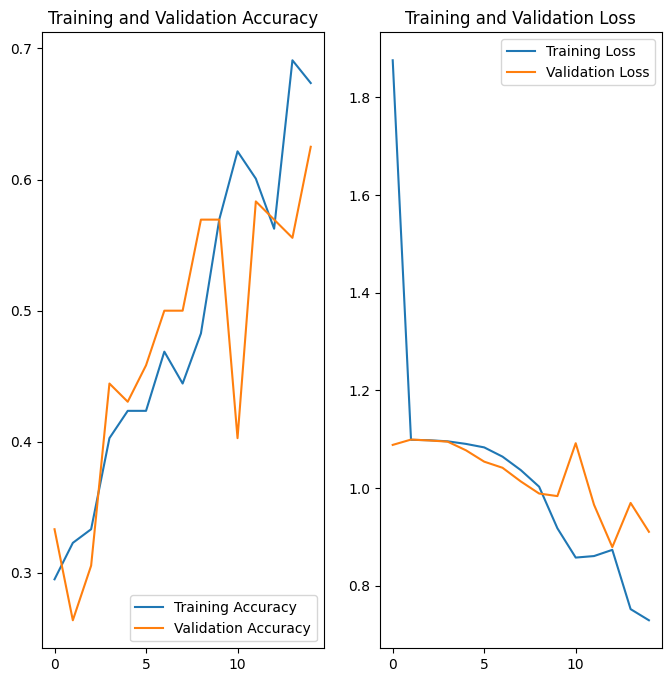

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import requests
import json

# Enter the name of your favorite author
author_name = "J.K. Rowling"

# Search for the author's ID based on the given name
search_url = "https://openlibrary.org/search/authors.json"
params = {"q": author_name}
response = requests.get(search_url, params=params)
data = json.loads(response.content)

# Check if any author was found
if "docs" not in data or len(data["docs"]) == 0:
    print("Author not found.")
    exit()

# Get the author's key (ID) from the search results
author_key = data["docs"][0]["key"]

# Get the author's data from the Open Library API using the author's key
url = "https://openlibrary.org{}/works.json".format(author_key)
response = requests.get(url)
data = json.loads(response.content)

# Count the number of books the author has written
number_of_books = len(data)

# Print the titles of the author's books
for work in data:
    print(work["title"])

print("The author has written {} books.".format(number_of_books))


ConnectionError: ignored